In [84]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

from sklearn import linear_model
from sklearn import metrics

from sklearn.feature_selection import RFE


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler

from scipy.stats import skew

sns.set(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')

## 1.0 Read and inspect the data

In [85]:
housesdf = pd.read_csv('train.csv')

In [86]:
housesdf.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [87]:
shape_orig = housesdf.shape
print(f'Initial dataset size = {shape_orig}')

Initial dataset size = (1460, 81)


In [88]:
print(housesdf.MasVnrArea.dtype)
housesdf.info()

float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      14

In [89]:
#housesdf.describe()

### 1.1 Observations on inspection
- There are quite a few null-values in the dataset
- SalePrice also has many outliers - it needs to be investigated further

In [90]:
null_pct = round(housesdf.isnull().sum()*100/shape_orig[0], 2)
print(null_pct[null_pct > 40.0])
print(null_pct[(null_pct > 0.0) & (null_pct < 40.0)])

Alley          93.77
FireplaceQu    47.26
PoolQC         99.52
Fence          80.75
MiscFeature    96.30
dtype: float64
LotFrontage     17.74
MasVnrType       0.55
MasVnrArea       0.55
BsmtQual         2.53
BsmtCond         2.53
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtFinType2     2.60
Electrical       0.07
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
dtype: float64


## 2.0 Data Cleaning
### 2.1 Observations - Null values
- The following columns have > 40% null values and can be dropped:
    1. Alley
    2. FireplaceQu
    3. PoolQC
    4. Fence
    5. MiscFeature
- We drop these by choosing all columns with null percentage > 40

In [91]:
print(null_pct[null_pct > 40].index)
drop_cols = null_pct[null_pct > 40].index
print(drop_cols)
housesdf = housesdf.drop(drop_cols, axis = 1)

Index(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')
Index(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')


In [92]:
shape1 = housesdf.shape
print(shape1)

(1460, 76)


### 2.2 Imputing NAs
We imput the different columns as below:
- Numeric variables: using mean
- Categorical Variables - those cases which have NA for indicating non-availability of of the feature will be imputed with **"No"**
- Categorical Variables - those cases which have NA for other general cases will be imputed with the mode

In [93]:
print(f"mean(LotFrontage) before imputation = {housesdf['LotFrontage'].mean()}")
housesdf.loc[np.isnan(housesdf['LotFrontage']), ['LotFrontage']] = housesdf['LotFrontage'].mean()
print(f"mean(LotFrontage) after imputation = {housesdf['LotFrontage'].mean()}")

mean(LotFrontage) before imputation = 70.04995836802665
mean(LotFrontage) after imputation = 70.04995836802642


In [94]:
print("Value Counts fraction pre-imputation")
print("="*36)
print(housesdf.MasVnrType.value_counts(normalize = True))
print(f'mode: {housesdf.MasVnrType.mode()}')
mode_MasVnrType = housesdf.MasVnrType.mode()[0]
housesdf.MasVnrType.fillna(mode_MasVnrType, inplace = True)
print("Value Counts fraction post-imputation")
print("="*37)
print(housesdf.MasVnrType.value_counts(normalize = True))

Value Counts fraction pre-imputation
None       0.595041
BrkFace    0.306474
Stone      0.088154
BrkCmn     0.010331
Name: MasVnrType, dtype: float64
mode: 0    None
dtype: object
Value Counts fraction post-imputation
None       0.597260
BrkFace    0.304795
Stone      0.087671
BrkCmn     0.010274
Name: MasVnrType, dtype: float64


In [95]:
# MasVnrArea = 0 for all cases of MasVnrType = None
# We have replaced null values in MasVnrType with None
# So, we've to replace null values of MasVnrArea with 0 and NOT WITH mean

print(f"mean(MasVnrArea) before imputation: {housesdf['MasVnrArea'].mean()}")
housesdf.loc[np.isnan(housesdf['MasVnrArea']), ['MasVnrArea']] = 0.0
print(f"mean(MasVnrArea) after imputation: {housesdf['MasVnrArea'].mean()}")
housesdf['MasVnrArea'].isnull().sum()

mean(MasVnrArea) before imputation: 103.68526170798899
mean(MasVnrArea) after imputation: 103.11712328767123


0

- Henceforth, the first set of values are before imputation, while the second set are after imputation
- Null values (NA) of **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, GarageType**, will be replaced with **No** since these values mean non-availability of these features

In [96]:
print(housesdf.BsmtQual.value_counts(normalize = True))
housesdf.BsmtQual.fillna('No', inplace = True)
print(housesdf.BsmtQual.value_counts(normalize = True))

TA    0.456079
Gd    0.434294
Ex    0.085032
Fa    0.024596
Name: BsmtQual, dtype: float64
TA    0.444521
Gd    0.423288
Ex    0.082877
No    0.025342
Fa    0.023973
Name: BsmtQual, dtype: float64


In [97]:
print(housesdf.BsmtCond.value_counts(normalize = True))
housesdf.BsmtCond.fillna('No', inplace = True)
print(housesdf.BsmtCond.value_counts(normalize = True))

TA    0.921293
Gd    0.045678
Fa    0.031623
Po    0.001405
Name: BsmtCond, dtype: float64
TA    0.897945
Gd    0.044521
Fa    0.030822
No    0.025342
Po    0.001370
Name: BsmtCond, dtype: float64


In [98]:
print(housesdf.BsmtExposure.value_counts(normalize = True))
housesdf.BsmtExposure.fillna('Nobsmt', inplace = True)
print(housesdf.BsmtExposure.value_counts(normalize = True))

No    0.670183
Av    0.155415
Gd    0.094233
Mn    0.080169
Name: BsmtExposure, dtype: float64
No        0.652740
Av        0.151370
Gd        0.091781
Mn        0.078082
Nobsmt    0.026027
Name: BsmtExposure, dtype: float64


In [99]:
print(housesdf.BsmtFinType1.value_counts(normalize = True))
housesdf.BsmtFinType1.fillna('No', inplace = True)
print(housesdf.BsmtFinType1.value_counts(normalize = True))

Unf    0.302178
GLQ    0.293746
ALQ    0.154603
BLQ    0.104006
Rec    0.093465
LwQ    0.052003
Name: BsmtFinType1, dtype: float64
Unf    0.294521
GLQ    0.286301
ALQ    0.150685
BLQ    0.101370
Rec    0.091096
LwQ    0.050685
No     0.025342
Name: BsmtFinType1, dtype: float64


In [100]:
print(housesdf.BsmtFinType2.value_counts(normalize = True))
housesdf.BsmtFinType2.fillna('No', inplace = True)
print(housesdf.BsmtFinType2.value_counts(normalize = True))

Unf    0.883263
Rec    0.037975
LwQ    0.032349
BLQ    0.023207
ALQ    0.013361
GLQ    0.009845
Name: BsmtFinType2, dtype: float64
Unf    0.860274
Rec    0.036986
LwQ    0.031507
No     0.026027
BLQ    0.022603
ALQ    0.013014
GLQ    0.009589
Name: BsmtFinType2, dtype: float64


In [101]:
print(housesdf.GarageType.value_counts(normalize = True))
housesdf.GarageType.fillna('No', inplace = True)
print(housesdf.GarageType.value_counts(normalize = True))

Attchd     0.630892
Detchd     0.280638
BuiltIn    0.063814
Basment    0.013778
CarPort    0.006526
2Types     0.004351
Name: GarageType, dtype: float64
Attchd     0.595890
Detchd     0.265068
BuiltIn    0.060274
No         0.055479
Basment    0.013014
CarPort    0.006164
2Types     0.004110
Name: GarageType, dtype: float64


In [102]:
# The attribute GarageYrBlt does not have a significant bearing on the SalePrice
# The variable YearBuilt is has a significant effect.
# So, we drop the variable GarageYrBlt
housesdf = housesdf.drop(['GarageYrBlt'], axis = 1)

In [103]:
print(housesdf.GarageFinish.value_counts(normalize = True))
housesdf.GarageFinish.fillna('No', inplace = True)
print(housesdf.GarageFinish.value_counts(normalize = True))

Unf    0.438724
RFn    0.306019
Fin    0.255257
Name: GarageFinish, dtype: float64
Unf    0.414384
RFn    0.289041
Fin    0.241096
No     0.055479
Name: GarageFinish, dtype: float64


In [104]:
print(housesdf.GarageQual.value_counts(normalize = True))
housesdf.GarageQual.fillna('No', inplace = True)
print(housesdf.GarageQual.value_counts(normalize = True))

TA    0.950689
Fa    0.034808
Gd    0.010152
Ex    0.002175
Po    0.002175
Name: GarageQual, dtype: float64
TA    0.897945
No    0.055479
Fa    0.032877
Gd    0.009589
Ex    0.002055
Po    0.002055
Name: GarageQual, dtype: float64


In [105]:
print(housesdf.GarageCond.value_counts(normalize = True))
housesdf.GarageCond.fillna('No', inplace = True)
print(housesdf.GarageCond.value_counts(normalize = True))

TA    0.961566
Fa    0.025381
Gd    0.006526
Po    0.005076
Ex    0.001450
Name: GarageCond, dtype: float64
TA    0.908219
No    0.055479
Fa    0.023973
Gd    0.006164
Po    0.004795
Ex    0.001370
Name: GarageCond, dtype: float64


In [106]:
# Since Electrical has only 0.07% rows as NA, meaning 0.0007*1460 = 1 row, we decide to drop that row
housesdf = housesdf[~housesdf.Electrical.isnull()]

In [107]:
final_shape = housesdf.shape
print(final_shape)

(1459, 75)


In [108]:
null_pct = round(housesdf.isnull().sum()*100/shape_orig[0], 2)
print(null_pct[null_pct > 40.0])
print(null_pct[(null_pct > 0.0) & (null_pct < 40.0)])

Series([], dtype: float64)
Series([], dtype: float64)


- Now, there are no null values in the dataset
- Only 1 row has been reduced in the dataset

## 3.0 EDA and encoding
### 3.1 Encoding of ordinal variables
- Here, we do some EDA to check whether the remaining variables are ordinal or whether they have to be encoded using dummy variables

Reg    0.633310
IR1    0.331734
IR2    0.028101
IR3    0.006854
Name: LotShape, dtype: float64
LotShape
IR1    0.377885
IR2    0.037250
IR3    0.008184
Reg    0.576681
Name: SalePrice, dtype: float64


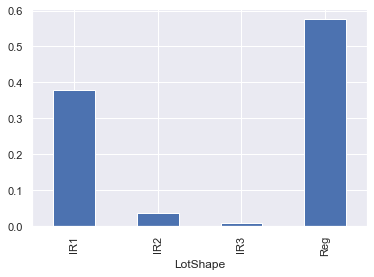

In [109]:
print(housesdf.LotShape.value_counts(normalize = True))
print(housesdf.groupby(['LotShape'])['SalePrice'].sum()/housesdf.SalePrice.sum())
(housesdf.groupby(['LotShape'])['SalePrice'].sum()/housesdf.SalePrice.sum()).plot.bar()
plt.show()

Lvl    0.897875
Bnk    0.043180
HLS    0.034270
Low    0.024674
Name: LandContour, dtype: float64
LandContour
Bnk    0.034153
HLS    0.043855
Low    0.027774
Lvl    0.894218
Name: SalePrice, dtype: float64


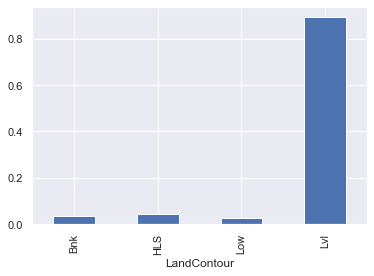

In [110]:
print(housesdf.LandContour.value_counts(normalize = True))
print(housesdf.groupby(['LandContour'])['SalePrice'].sum()/housesdf.SalePrice.sum())
(housesdf.groupby(['LandContour'])['SalePrice'].sum()/housesdf.SalePrice.sum()).plot.bar()
plt.show()

Inside     0.720356
Corner     0.180260
CulDSac    0.064428
FR2        0.032214
FR3        0.002742
Name: LotConfig, dtype: float64
LotConfig
Corner     0.180951
CulDSac    0.079713
FR2        0.031680
FR3        0.003159
Inside     0.704497
Name: SalePrice, dtype: float64


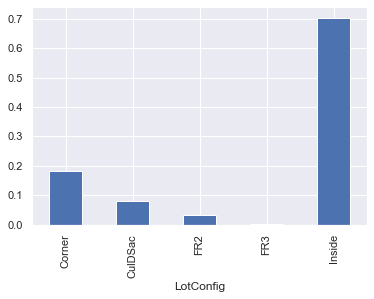

In [111]:
print(housesdf.LotConfig.value_counts(normalize = True))
print(housesdf.groupby(['LotConfig'])['SalePrice'].sum()/housesdf.SalePrice.sum())
(housesdf.groupby(['LotConfig'])['SalePrice'].sum()/housesdf.SalePrice.sum()).plot.bar()
plt.show()

NAmes      0.154215
CollgCr    0.102810
OldTown    0.077450
Edwards    0.068540
Somerst    0.058944
Gilbert    0.054147
NridgHt    0.052776
Sawyer     0.050720
NWAmes     0.050034
SawyerW    0.040439
BrkSide    0.039753
Crawfor    0.034955
Mitchel    0.033585
NoRidge    0.028101
Timber     0.025360
IDOTRR     0.025360
ClearCr    0.019191
SWISU      0.017135
StoneBr    0.017135
MeadowV    0.011652
Blmngtn    0.011652
BrDale     0.010966
Veenker    0.007539
NPkVill    0.006169
Blueste    0.001371
Name: Neighborhood, dtype: float64
Neighborhood
Blmngtn    0.012550
Blueste    0.001042
BrDale     0.006333
BrkSide    0.027428
ClearCr    0.022547
CollgCr    0.112490
Crawfor    0.040692
Edwards    0.048572
Gilbert    0.057715
IDOTRR     0.014034
MeadowV    0.006348
Mitchel    0.029007
NAmes      0.124312
NPkVill    0.004865
NWAmes     0.052280
NoRidge    0.052077
NridgHt    0.092253
OldTown    0.054889
SWISU      0.013504
Sawyer     0.038347
SawyerW    0.041696
Somerst    0.073425
StoneBr    0

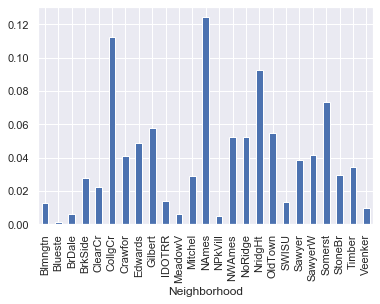

In [112]:
print(housesdf.Neighborhood.value_counts(normalize = True))
print(housesdf.groupby(['Neighborhood'])['SalePrice'].sum()/housesdf.SalePrice.sum())
(housesdf.groupby(['Neighborhood'])['SalePrice'].sum()/housesdf.SalePrice.sum()).plot.bar()
plt.show()

SBrkr    0.914325
FuseA    0.064428
FuseF    0.018506
FuseP    0.002056
Mix      0.000685
Name: Electrical, dtype: float64
Electrical
FuseA    0.043513
FuseF    0.011013
FuseP    0.001106
Mix      0.000254
SBrkr    0.944114
Name: SalePrice, dtype: float64


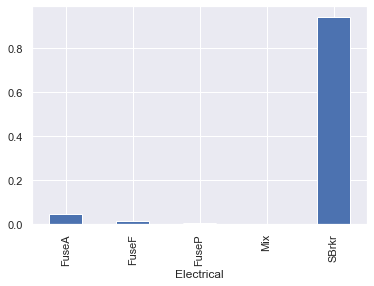

In [113]:
print(housesdf.Electrical.value_counts(normalize = True))
print(housesdf.groupby(['Electrical'])['SalePrice'].sum()/housesdf.SalePrice.sum())
(housesdf.groupby(['Electrical'])['SalePrice'].sum()/housesdf.SalePrice.sum()).plot.bar()
plt.show()

### 3.2 Observations - ordinal/not-ordinal
- None of the above variables are ordinal, since they really don't have an order in them
- The bar-plots are plotted just to check the number values and their total value
- This will help us in realizing whether they are ordinal - if the number of occurances is high and the **SalePrice** is also equally high, then it means the price is high only because there are too many values
- However if the number of values is not exactly proportionate to the **SalePrice** that is becasue it is a higher level quantity and so this signifies an ordinal variable

### 3.3 Encoding of Ordinal variables
- All the variables below are **ordinal** and are encoded (actually mapped) as such

In [114]:
# Street (2), Utilities (4), HouseStyle (8), ExterQual (5), ExterCond (5), BsmtQual (6), BsmtCond (6),
# BsmtExposure (5), BsmtFinType1 (7), BsmtFinType2 (7), HeatingQC (5), CentralAir (2), KitchenQual (5), 
# GarageFinish (4), GarageQual (6), GarageCond (6), PavedDrive (3)

street_map = {
    'Grvl': 0, 
    'Pave': 1
}
housesdf['StreetLvl'] = housesdf.Street.map(street_map)
housesdf.head()

utilities_map = {
    'ELO': 0,
    'NoSeWa': 1,
    'NoSewr': 2,
    'AllPub': 3
}
housesdf['UtilitiesLvl'] = housesdf.Utilities.map(utilities_map)
housesdf.head()

housestyle_map = {
    '1Story': 0, 
    '1.5Unf': 1, 
    '1.5Fin': 2,
    '2Story': 3,
    '2.5Unf': 4,
    '2.5Fin': 5, 
    'SFoyer': 6, 
    'SLvl': 7
}
housesdf['HouseStyleLvl'] = housesdf.HouseStyle.map(housestyle_map)
housesdf.head()

exterqual_map = {
    'Po': 0, 
    'Fa': 1, 
    'TA': 2,
    'Gd': 3,
    'Ex': 4
}
housesdf['ExterQualLvl'] = housesdf.ExterQual.map(exterqual_map)
housesdf.head()

housesdf['ExterCondLvl'] = housesdf.ExterCond.map(exterqual_map)
housesdf.head()

bsmtqual_map = {
    'No': 0,
    'Po': 1, 
    'Fa': 2, 
    'TA': 3,
    'Gd': 4,
    'Ex': 5
}
housesdf['BsmtQualLvl'] = housesdf.BsmtQual.map(bsmtqual_map)
housesdf.head()

housesdf['BsmtCondLvl'] = housesdf.BsmtCond.map(bsmtqual_map)
housesdf.head()

bsmtexp_map = {
    'Nobsmt': 0,
    'No': 1, 
    'Mn': 2, 
    'Av': 3,
    'Gd': 4
}
housesdf['BsmtExposureLvl'] = housesdf.BsmtExposure.map(bsmtexp_map)
housesdf.head()

bsmtft1_map = {
    'No': 0,
    'Unf': 1,
    'LwQ': 2, 
    'Rec': 3,
    'BLQ': 4,
    'ALQ': 5,
    'GLQ': 6
}
housesdf['BsmtFinTypeLvl1'] = housesdf.BsmtFinType1.map(bsmtft1_map)
housesdf.head()

housesdf['BsmtFinTypeLvl2'] = housesdf.BsmtFinType2.map(bsmtft1_map)
housesdf.head()

heatqc_map = {
    'Po': 1, 
    'Fa': 2, 
    'TA': 3,
    'Gd': 4,
    'Ex': 5
}
housesdf['HeatingQCLvl1'] = housesdf.HeatingQC.map(heatqc_map)
housesdf.head()

ac_map = {
    'N': 0, 
    'Y': 1
}
housesdf['CentralAirLvl'] = housesdf.CentralAir.map(ac_map)
housesdf.head()

housesdf['KitchenQualLvl'] = housesdf.KitchenQual.map(heatqc_map)
housesdf.head()

garagefin_map = {
    'No': 0,
    'Unf': 1,
    'RFn': 2,
    'Fin': 3
}
housesdf['GarageFinishLvl'] = housesdf.GarageFinish.map(garagefin_map)
housesdf.head()

housesdf['GarageQualLvl'] = housesdf.GarageQual.map(bsmtqual_map)
housesdf.head()

housesdf['GarageCondLvl'] = housesdf.GarageCond.map(bsmtqual_map)
housesdf.head()

drive_map = {
    'N': 0,
    'P': 1,
    'Y': 2
}
housesdf['PavedDriveLvl'] = housesdf.PavedDrive.map(drive_map)
housesdf.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,BsmtExposureLvl,BsmtFinTypeLvl1,BsmtFinTypeLvl2,HeatingQCLvl1,CentralAirLvl,KitchenQualLvl,GarageFinishLvl,GarageQualLvl,GarageCondLvl,PavedDriveLvl
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,1,6,1,5,1,4,2,3,3,2
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,4,5,1,5,1,3,2,3,3,2
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,2,6,1,5,1,4,2,3,3,2
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,1,5,1,4,1,4,1,3,3,2
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,3,6,1,5,1,4,2,3,3,2


* The variables corresponding to all the mapped variables are dropped below

In [115]:
# Street (2), Utilities (4), HouseStyle (8), ExterQual (5), ExterCond (5), BsmtQual (6), BsmtCond (6),
# BsmtExposure (5), BsmtFinType1 (7), BsmtFinType2 (7), HeatingQC (5), CentralAir (2), KitchenQual (5), 
# GarageFinish (4), GarageQual (6), GarageCond (6), PavedDrive (3)

dropcols2 = ['Street', 'Utilities', 'HouseStyle', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
            'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'KitchenQual', 'GarageFinish',
            'GarageQual', 'GarageCond', 'PavedDrive']
housesdf = housesdf.drop(dropcols2, axis = 1)
shape_cur = housesdf.shape
print(shape_cur)
housesdf.head()

(1459, 75)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,BsmtExposureLvl,BsmtFinTypeLvl1,BsmtFinTypeLvl2,HeatingQCLvl1,CentralAirLvl,KitchenQualLvl,GarageFinishLvl,GarageQualLvl,GarageCondLvl,PavedDriveLvl
0,1,60,RL,65.0,8450,Reg,Lvl,Inside,Gtl,CollgCr,...,1,6,1,5,1,4,2,3,3,2
1,2,20,RL,80.0,9600,Reg,Lvl,FR2,Gtl,Veenker,...,4,5,1,5,1,3,2,3,3,2
2,3,60,RL,68.0,11250,IR1,Lvl,Inside,Gtl,CollgCr,...,2,6,1,5,1,4,2,3,3,2
3,4,70,RL,60.0,9550,IR1,Lvl,Corner,Gtl,Crawfor,...,1,5,1,4,1,4,1,3,3,2
4,5,60,RL,84.0,14260,IR1,Lvl,FR2,Gtl,NoRidge,...,3,6,1,5,1,4,2,3,3,2


### 3.4 Dummy encoding

In [116]:
# We drop Condition2 variable since it does not give add extra information to predicting Sales
# We can get all the information using Condition1

housesdf = housesdf.drop(['Condition2'], axis = 1)

* Seeing the above plots, we find that **`OverallQual`** does have an impact on **`SalePrice`**
* However, **`OverallCond`** does not have a major impact at all. Infact, at 5, `SalePrice` is highest
* So, we decide to drop it
* Again `Exterior1st` and `Exterior2nd` are similar and one of them can be dropped
* We decide to drop `Exterior2nd`

In [117]:
housesdf = housesdf.drop(['OverallQual', 'Exterior2nd', 'MoSold', 'YrSold'], axis = 1)

**Neighbourhood**
- `Neighbourhood` has a number of categories
- If dummies are created, it adds too many columns to the dataset
- Let's check if it has any effect on the target variable by plotting `SalePrice` against it

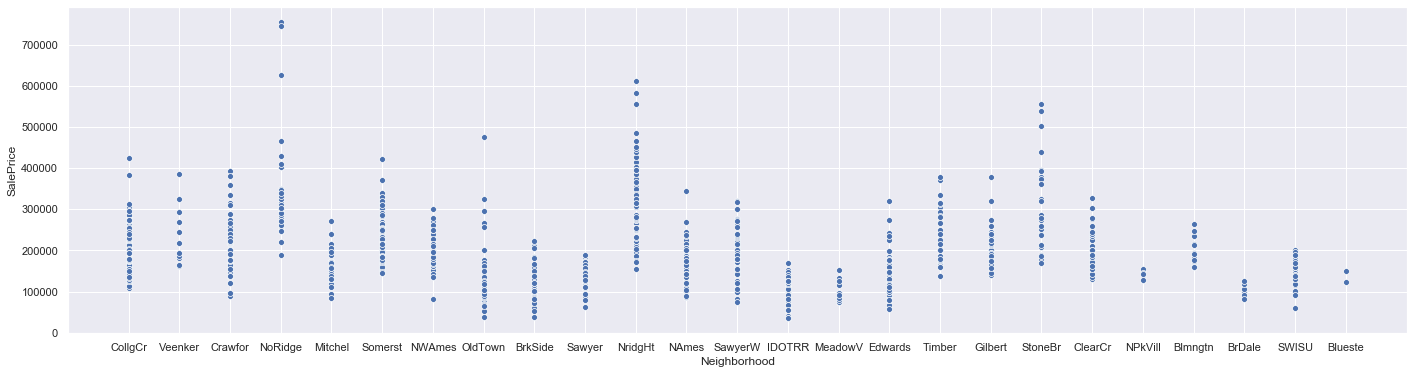

In [118]:
plt.figure(figsize = (24, 6))
sns.scatterplot(x = 'Neighborhood', y = 'SalePrice', data = housesdf)
plt.show()

- We see, however, that houses in certain neighbourhoods are indeed highly priced
- So, we decide to retain this and create dummy variabes

In [119]:
# vars: MSSubClass, MSZoning, LotShape, LandContour, LotConfig, LandSlope, Neighborhood, 
# Condition1, RoofStyle, RoofMatl, Exterior1st, MasVnrType, Heating, Functional, GarageType, MiscFeature
# SaleType, SaleCondition

# Creating dummy variables for the variable 'MSSubClass'
m1 = pd.get_dummies(housesdf['MSSubClass'], prefix='MSSubClass', drop_first = True)

m2 = pd.get_dummies(housesdf['MSZoning'], prefix='MSZoning', drop_first = True)

m3 = pd.get_dummies(housesdf['LotShape'], prefix='LotShape', drop_first = True)

m4 = pd.get_dummies(housesdf['LandContour'], prefix='LandContour', drop_first = True)

m5 = pd.get_dummies(housesdf['LotConfig'], prefix='LotConfig', drop_first = True)

m6 = pd.get_dummies(housesdf['LandSlope'], prefix='LandSlope', drop_first = True)

m7 = pd.get_dummies(housesdf['Neighborhood'], prefix='Neighborhood', drop_first = True)

m8 = pd.get_dummies(housesdf['Condition1'], prefix='Condition1', drop_first = True)

m9 = pd.get_dummies(housesdf['RoofStyle'], prefix='RoofStyle', drop_first = True)

m10 = pd.get_dummies(housesdf['RoofMatl'], prefix='RoofMatl', drop_first = True)

m11 = pd.get_dummies(housesdf['Exterior1st'], prefix='Exterior1st', drop_first = True)

m12 = pd.get_dummies(housesdf['MasVnrType'], prefix='MasVnrType', drop_first = True)

m13 = pd.get_dummies(housesdf['Heating'], prefix='Heating', drop_first = True)

m14 = pd.get_dummies(housesdf['Functional'], prefix='Functional', drop_first = True)

m15 = pd.get_dummies(housesdf['GarageType'], prefix='GarageType', drop_first = True)

m16 = pd.get_dummies(housesdf['SaleType'], prefix='SaleType', drop_first = True)

m17 = pd.get_dummies(housesdf['SaleCondition'], prefix='SaleCondition', drop_first = True)

m18 = pd.get_dummies(housesdf['BldgType'], prefix='BldgType', drop_first = True)

m19 = pd.get_dummies(housesdf['Foundation'], prefix='Foundation', drop_first = True)

m20 = pd.get_dummies(housesdf['Electrical'], prefix='Electrical', drop_first = True)

**Column Replacemnt:**
- We will now add the columns with dummy variables we just created, and remove their parent columns
- This will drastically increase the number of columns, so, we will use RFE to reduce the number of variables to manageable levels

In [120]:
addCols = [housesdf, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12, m13, m14, m15, m16, m17, m18, m19, m20]
housesdf = pd.concat(addCols, axis = 1)
housesdf.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,BldgType_TwnhsE,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr
0,1,60,RL,65.0,8450,Reg,Lvl,Inside,Gtl,CollgCr,...,0,0,1,0,0,0,0,0,0,1
1,2,20,RL,80.0,9600,Reg,Lvl,FR2,Gtl,Veenker,...,0,1,0,0,0,0,0,0,0,1
2,3,60,RL,68.0,11250,IR1,Lvl,Inside,Gtl,CollgCr,...,0,0,1,0,0,0,0,0,0,1
3,4,70,RL,60.0,9550,IR1,Lvl,Corner,Gtl,Crawfor,...,0,0,0,0,0,0,0,0,0,1
4,5,60,RL,84.0,14260,IR1,Lvl,FR2,Gtl,NoRidge,...,0,0,1,0,0,0,0,0,0,1


In [121]:
# Just check the current size of the data-frame
shape_curr = housesdf.shape
print(shape_curr)

(1459, 204)


In [122]:
# Drop the columns for which dummy variables have been created
dropCols = ['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 
'Condition1', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'MasVnrType', 'Heating', 'Functional', 'GarageType','SaleType', 
'SaleCondition', 'BldgType', 'Foundation', 'Electrical']
housesdf = housesdf.drop(dropCols, axis = 1)
housesdf.head()

,Id,LotFrontage,LotArea,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,BldgType_TwnhsE,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr
0,1,65.0,8450,5,2003,2003,196.0,706,0,150,...,0,0,1,0,0,0,0,0,0,1
1,2,80.0,9600,8,1976,1976,0.0,978,0,284,...,0,1,0,0,0,0,0,0,0,1
2,3,68.0,11250,5,2001,2002,162.0,486,0,434,...,0,0,1,0,0,0,0,0,0,1
3,4,60.0,9550,5,1915,1970,0.0,216,0,540,...,0,0,0,0,0,0,0,0,0,1
4,5,84.0,14260,5,2000,2000,350.0,655,0,490,...,0,0,1,0,0,0,0,0,0,1


In [123]:
# Check the shape of the DF after dropping the columns for which dummy variables have been created
shape_curr = housesdf.shape
print(shape_curr)

(1459, 184)


### 3.5 Date-time columns:
- The year in which the house was built or in which it was modified, in themselves don't give much info
- However, we can use the year to find the age of the building itself or the no. of years since it was remodified
- This age would undoubtedly be a useful variable in predicting house prices

In [124]:
# Subtract the current year from 'YearBuilt' to get the age of the ouse
housesdf.YearBuilt.head()
curr_yr = pd.Timestamp('now').year
housesdf['BuildingAge'] = curr_yr - housesdf.YearBuilt

housesdf = housesdf.drop(['YearBuilt'], axis = 1)
housesdf.head()

,Id,LotFrontage,LotArea,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,BuildingAge
0,1,65.0,8450,5,2003,196.0,706,0,150,856,...,0,1,0,0,0,0,0,0,1,17
1,2,80.0,9600,8,1976,0.0,978,0,284,1262,...,1,0,0,0,0,0,0,0,1,44
2,3,68.0,11250,5,2002,162.0,486,0,434,920,...,0,1,0,0,0,0,0,0,1,19
3,4,60.0,9550,5,1970,0.0,216,0,540,756,...,0,0,0,0,0,0,0,0,1,105
4,5,84.0,14260,5,2000,350.0,655,0,490,1145,...,0,1,0,0,0,0,0,0,1,20


In [125]:
# Subtract the current year from the year when the house was remodified, to get the years since remodification
housesdf.YearRemodAdd.head()
curr_yr = pd.Timestamp('now').year
remod_age = curr_yr - housesdf.YearRemodAdd

housesdf['RemodAge'] = remod_age
housesdf = housesdf.drop(['YearRemodAdd'], axis = 1)
housesdf.head()

,Id,LotFrontage,LotArea,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,BuildingAge,RemodAge
0,1,65.0,8450,5,196.0,706,0,150,856,856,...,1,0,0,0,0,0,0,1,17,17
1,2,80.0,9600,8,0.0,978,0,284,1262,1262,...,0,0,0,0,0,0,0,1,44,44
2,3,68.0,11250,5,162.0,486,0,434,920,920,...,1,0,0,0,0,0,0,1,19,18
3,4,60.0,9550,5,0.0,216,0,540,756,961,...,0,0,0,0,0,0,0,1,105,50
4,5,84.0,14260,5,350.0,655,0,490,1145,1145,...,1,0,0,0,0,0,0,1,20,20


In [126]:
#housesdf.RemodAge = housesdf.BuildingAge - housesdf.RemodAge
print(sum(housesdf.RemodAge != 0))
print(sum(housesdf.RemodAge == 0))
housesdf.RemodAge

1459
0


0       17
1       44
2       18
3       50
4       20
        ..
1455    20
1456    32
1457    14
1458    24
1459    55
Name: RemodAge, Length: 1459, dtype: int64

**3.5.1 EDA - Effect of BuildingAge and remod_age on SalePrice:**
- We now plot SalePrice vs Building Age and RemodAge
- We see the following:
    - As building age increases, its SalePrice shows a downward trend, which is to be expected
    - RemodAge also shows a similar trend, but does not have as significant an effect on the SalePrice
    - The reason RemodAge shows a similar trend is because, in many cases if the house is never remodified, the RemodAge will be equal to the BuildingAge and so it shows prices based on BuildingAge

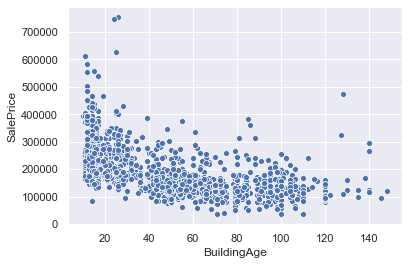

In [127]:
sns.scatterplot(x = 'BuildingAge', y = 'SalePrice', data = housesdf)
plt.show()

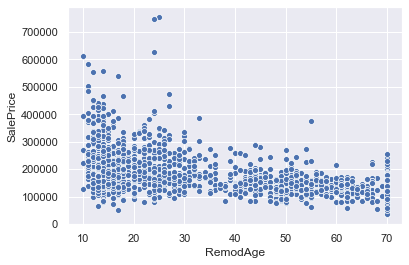

In [128]:
sns.scatterplot(x = 'RemodAge', y = 'SalePrice', data = housesdf)
plt.show()

### 3.6 Pair-plot of selected numerical columns:
- We now plot the pair-plots of some of the numeric variables, to find out relationships between them
- This will help us understand:
    - How the variables are related to SalePrice, i.e., which of these have linear relationship with SalePrice
    - How the variables are related among themselves, i.e., get an idea of **Multicollinearity**

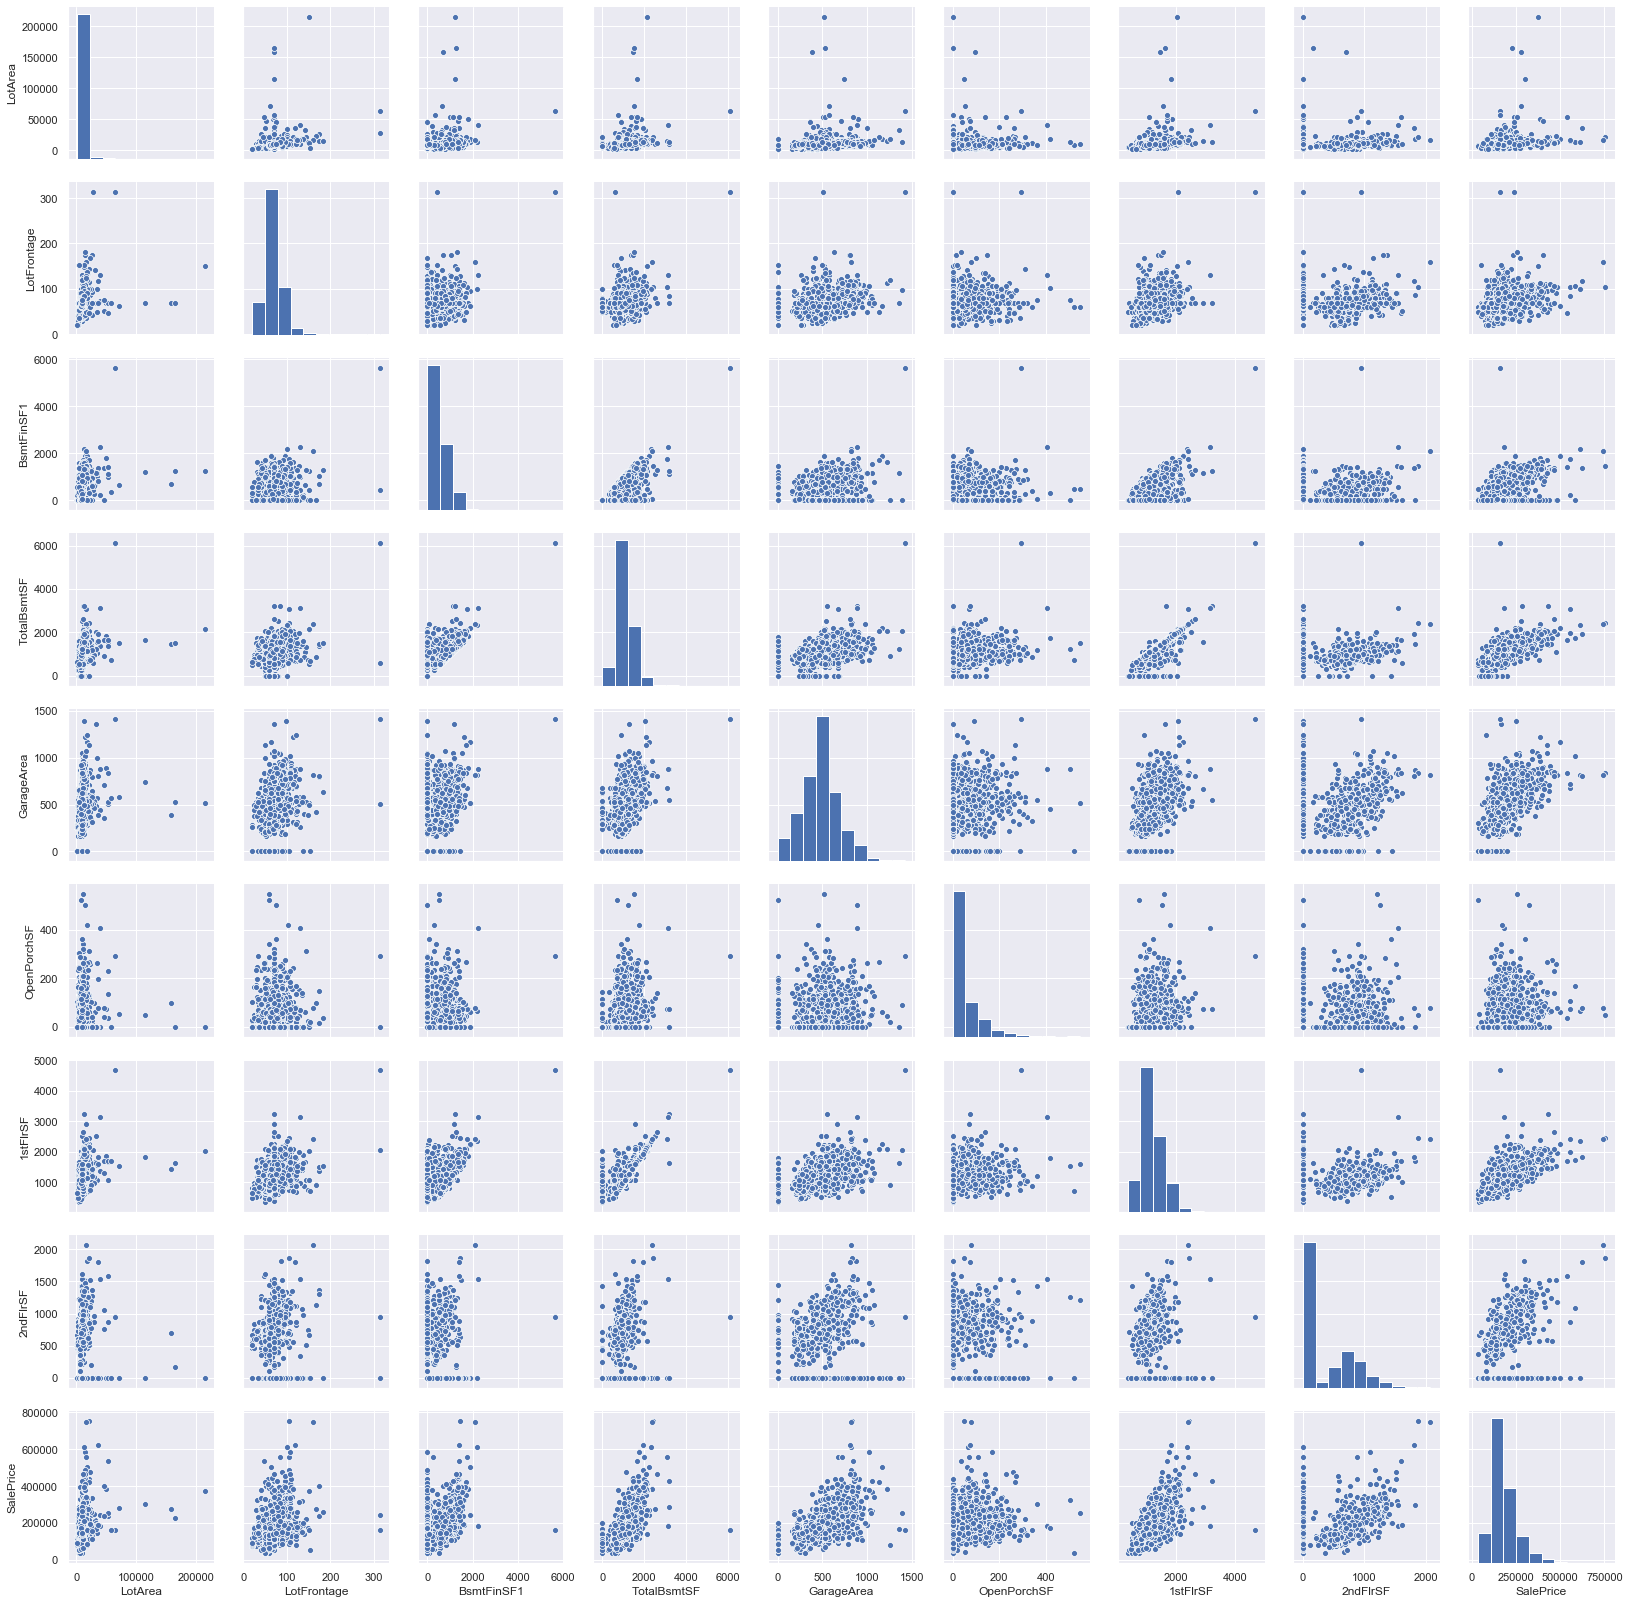

In [129]:
plotVars = ['LotArea', 'LotFrontage', 'BsmtFinSF1', 'TotalBsmtSF', 'GarageArea', 'OpenPorchSF', '1stFlrSF', '2ndFlrSF', 'SalePrice']

plotDf = housesdf[plotVars]

plotDf.head()

sns.pairplot(plotDf)
plt.show()

**3.6.1 Observations**
- The variables BsmtSF1, TotalBsmtSF, GrLivingArea, 1stFlrSF, 2ndFlrSF are related linearly to SalePrice
- Interestengly, LotArea and LotFrontage don't seem to be linearly related to SalePrice, 
    - Particularly LotArea shows very little linear relationship, while LotFrotnage is a bit better but not too good
    - This is a bit counterintuitive, since one would expect LotArea and LotFrontage to have a good linear relation to SalePrice
    - On the other hand, 1stFlrSF and 2ndFlrSF have a highly linear relationship to SalePrice
    - People probably prefer good 1st Floor area and 2nd Floor area
- However there appears to be quite a lot of multicollinearity here:
    - TotalBsmtSF, BsmtSF1
    - GrLivingArea-TotalBsmtSF
    - GrLivingArea-2ndFlrSF
    - GrLivingArea-1stFlrSF
    - 1stFlrSF-TotalBsmtSF
    - 2ndFlrSF-TotalBsmtSF
- This means that many of these variables will be removed for lack of significance (Eg. LotArea, LotFrontage) and many others will be removed due to Multicollinearity (GrLivingArea, TotalBsmtSF or 1sFlrSF or 2ndFlrSF?)

In [130]:
housesdf = housesdf.drop(['Id'], axis = 1)

### 3.7 Correlation
- Let's find the correlation among the above variables used for plotting
- That should give us a clearer picture of the linear-dependance of the different variables with SalePrice and also among themselves

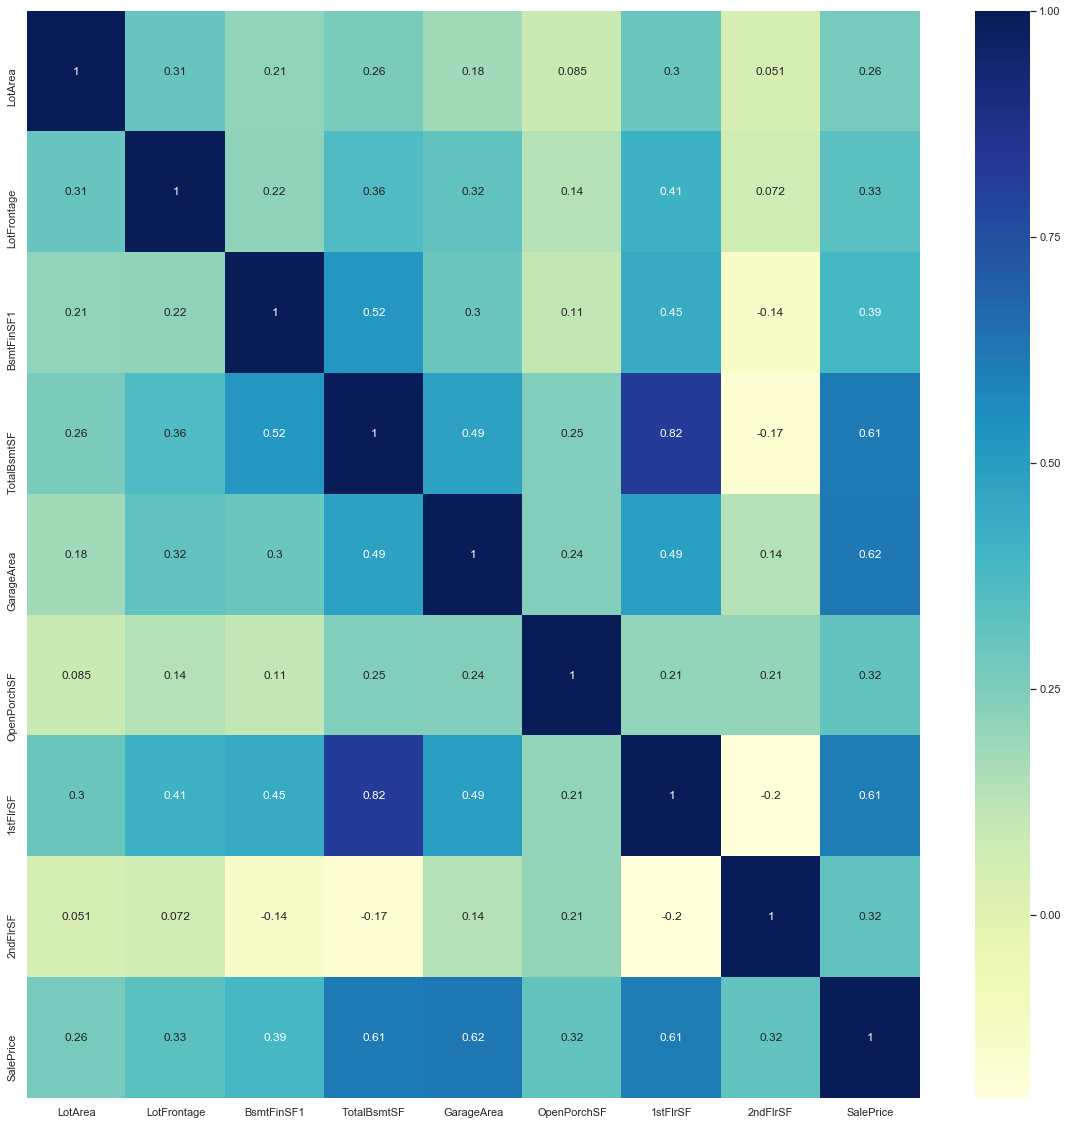

In [131]:
# Find and show correlation
plt.figure(figsize = (20, 20))
ax = sns.heatmap(housesdf[plotVars].corr(), annot = True, cmap = 'YlGnBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

#### 3.7.1 Observations
- We see that GrLivingArea, 1stFlrSF and TotalBsmtSF have very high correlation with SalePrice
- But TotalBsmtSF is highly correlated with 1stFlrSF and has a pretty good correlation with GrLivingArea
    - this shows Multicollinearity
- 1stFlrSF and BsmtFinSF1 are also well correlated
- This is further proof that some of these variables will be removed when RFE is done or when Lasso Regression is done

## 4.0 Split the data to train and test
We now split the DF into train and test sets, while also separating the target variable from the predictor variables

In [132]:
y = housesdf.pop('SalePrice')
X = housesdf

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 98)

## 5.0 EDA on the target variable

- We now do some EDA on the target variable, y_train
- We will observe this, draw conclusions from it and extend these conclusions to y_test as well
- We use box-plots and dist-plots for this

### 5.1 describe() and boxplot()

In [134]:
y_train.describe()

count      1167.000000
mean     179861.447301
std       79993.279977
min       34900.000000
25%      129000.000000
50%      161500.000000
75%      213500.000000
max      755000.000000
Name: SalePrice, dtype: float64

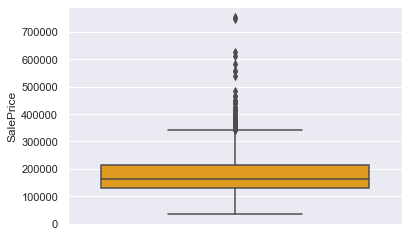

In [135]:
sns.boxplot(y_train, color = 'orange', orient = 'v')
plt.show()

#### 5.1.1 Observations
- We observe from describe() and boxplot() that the statistics of y_train are lopsided
- That is, they have a lot of outliers

### 5.2 Distplots

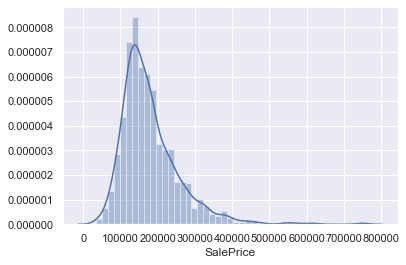

1.9965585037374936


In [136]:
sns.distplot(y_train)
plt.show()
skewness = skew(y_train)
print(skewness)

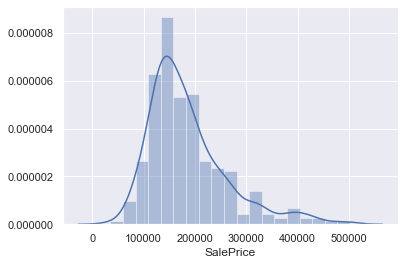

1.9965585037374936


In [137]:
sns.distplot(y_test)
plt.show()
skewness = skew(y_train)
print(skewness)

#### 5.2.1 Observations - Skewness
- We can see that the SalePrice (target) column is highly skewed
- We need to do a transformation on it to ensure it is purely normal, because that is the expectation of the target variable in Linear Regression - that the dependent variable shows a Gaussian distribution around its mean
- Further, we can see that the skewness is quite large since the skewness value is 1.99
- In order to ensure that the target variable is proper Gaussian, we need to remove skewness

### 5.3 Transforming the Target Variable

#### 5.3.1 Removing Skewness
- We try the following 3 methods to reduce skewness:
    - Square root transformation
    - Cube root transformation
    - Log transformation (in this case, we take log to natural base)
- We compare the skewness of the column after every transformation and take the best (i.e., one that reduces the skewness to the minimum)

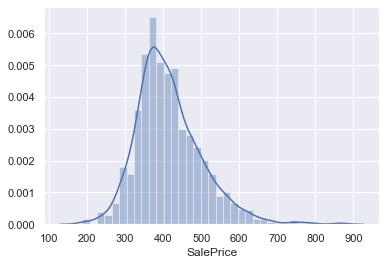

In [138]:
sp = np.sqrt(y_train)
sns.distplot(sp)
plt.show()

In [139]:
skewness = skew(sp)
print(skewness)

0.979905665652809


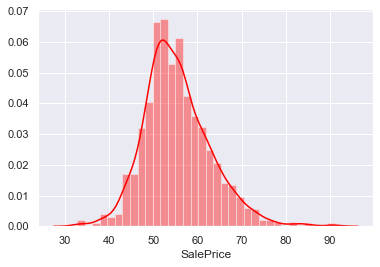

In [140]:
sp = np.power(y_train, 1.0/3)
sns.distplot(sp, color = 'red')
plt.show()

In [141]:
skewness = skew(sp)
print(skewness)

0.6884527184409828


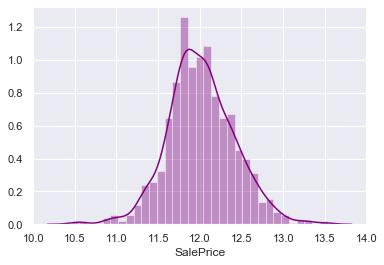

In [142]:
sp = np.log(y_train)
sns.distplot(sp, color = 'purple')
plt.show()

In [143]:
skewness = skew(sp)
print(skewness)

0.12588183127216523


#### 5.3.2 Observations
* We see the following:
    * skewness after square root transformation = `0.979905665652809`
    * skewness after cube root transformation = `0.6884527184409828`
    * skewness after log transformation = `0.12588183127216523`
* We can see from the above values that log is the best transformation
* Further,through the plot as well, we see that the best transformation is the log transformation
* We therefore decide to use the **log transformation** on the target column, i.e., SalePrice
* We do this transformation of both y_train and y_test since both these are skewed and skewness needs to be removed equally on both

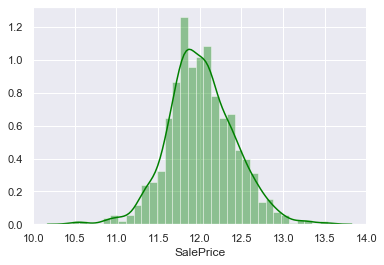

0.12588183127216523

In [144]:
y_train = np.log(y_train)
sns.distplot(y_train, color = 'green')
plt.show()
skew(y_train)

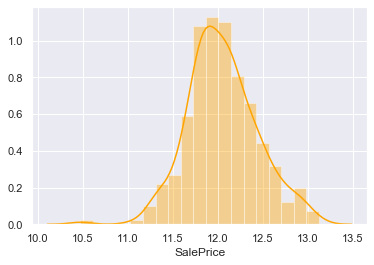

0.11715494012016742

In [145]:
y_test = np.log(y_test)
sns.distplot(y_test, color = 'orange')
plt.show()
skew(y_test)

## 6.0 Regression
### 6.1 Scaling
* We use the StandardScaler to scale the independent variables and hence, the dependent variable as well

In [146]:
scaler = StandardScaler()
num_vars = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
           '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
           'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
           'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

X_train[num_vars] = scaler.fit_transform(X_train[num_vars])

In [147]:
cols = X_train.columns

### 6.2 RFE
- Below, we run RFE and reduce the dimensionality of the independent variables to 25
- On this dataset of 25 variables, we run Ridge and Lasso Regression to finally get the model and predict the test set

In [148]:
lr_rfe = LinearRegression()
lr_rfe.fit(X_train, y_train)

rfe = RFE(lr_rfe, 25)
rfe = rfe.fit(X_train, y_train)

In [149]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('LotFrontage', False, 62),
 ('LotArea', False, 64),
 ('OverallCond', False, 24),
 ('MasVnrArea', False, 109),
 ('BsmtFinSF1', False, 20),
 ('BsmtFinSF2', False, 121),
 ('BsmtUnfSF', False, 150),
 ('TotalBsmtSF', False, 40),
 ('1stFlrSF', True, 1),
 ('2ndFlrSF', True, 1),
 ('LowQualFinSF', False, 28),
 ('GrLivArea', False, 21),
 ('BsmtFullBath', False, 69),
 ('BsmtHalfBath', False, 133),
 ('FullBath', False, 57),
 ('HalfBath', False, 59),
 ('BedroomAbvGr', False, 143),
 ('KitchenAbvGr', False, 55),
 ('TotRmsAbvGrd', False, 148),
 ('Fireplaces', False, 50),
 ('GarageCars', False, 14),
 ('GarageArea', False, 95),
 ('WoodDeckSF', False, 78),
 ('OpenPorchSF', False, 83),
 ('EnclosedPorch', False, 112),
 ('3SsnPorch', False, 111),
 ('ScreenPorch', False, 74),
 ('PoolArea', False, 156),
 ('MiscVal', False, 114),
 ('StreetLvl', False, 65),
 ('UtilitiesLvl', False, 35),
 ('HouseStyleLvl', False, 117),
 ('ExterQualLvl', False, 87),
 ('ExterCondLvl', False, 101),
 ('BsmtQualLvl', False, 10),
 (

In [150]:
col = X_train.columns[rfe.support_]
col

Index(['1stFlrSF', '2ndFlrSF', 'CentralAirLvl', 'MSSubClass_190',
       'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM',
       'Neighborhood_MeadowV', 'Neighborhood_NridgHt', 'Neighborhood_Veenker',
       'RoofStyle_Shed', 'RoofMatl_CompShg', 'RoofMatl_Metal', 'RoofMatl_Roll',
       'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl',
       'Exterior1st_BrkComm', 'Exterior1st_CBlock', 'Functional_Maj2',
       'Functional_Sev', 'Functional_Typ', 'BldgType_2fmCon',
       'BldgType_Duplex'],
      dtype='object')

In [151]:
X_train.columns[~rfe.support_]

Index(['LotFrontage', 'LotArea', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'LowQualFinSF', 'GrLivArea',
       ...
       'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone',
       'Foundation_Wood', 'Electrical_FuseF', 'Electrical_FuseP',
       'Electrical_Mix', 'Electrical_SBrkr', 'BuildingAge', 'RemodAge'],
      dtype='object', length=157)

In [152]:
X_train_rfe = X_train[col]
X_train_rfe.shape

(1167, 25)

## 7.0 Ordinary Linear Regression (Ordinary Least Squares)

- We now run Ordinary Least Squares on this reduced dataset, mainly to compare and contrast its performance with Regularized Regression
- We find the r2_score of OLS for train and test sets and compare it with those obtained from Ridge and Lasso regression

In [153]:
X_train_lm = sm.add_constant(X_train_rfe)

In [154]:
lr1 = sm.OLS(y_train,X_train_lm).fit()

In [155]:
lr1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     181.5
Date:                Mon, 02 Nov 2020   Prob (F-statistic):               0.00
Time:                        19:20:45   Log-Likelihood:                 344.11
No. Observations:                1167   AIC:                            -636.2
Df Residuals:                    1141   BIC:                            -504.6
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    8.2762      0.204     40.552      0.000       7.876       8.677
1stFlrSF                 0.2643      0.007     40.494      0.000       0.251       0.277
2ndFlrSF                 0.1823      0.006     32.718      0.000       0.171       0.193
CentralAirLvl            0.2674      0.023     11.459      0.000       0.222       0.313
MSSubClass_190          -0.4288      0.187     -2.289      0.022      -0.796      -0.061
MSZoning_FV              0.7347      0.071     10.403      0.000       0.596       0.873
MSZoning_RH              0.4742      0.082      5.762      0.000       0.313       0.636
MSZoning_RL              0.5344      0.066      8.074      0.000       0.405       0.664
MSZoning_RM              0.3938      0.067      5.890      0.000       0.263       0.525
Neighborhood_MeadowV    -0.1438      0.050     -2.896      0.004      -0.241      -0.046
Neighborhood_NridgHt     0.2776      0.025     11.198      0.000       0.229       0.326
Neighborhood_Veenker     0.2068      0.066      3.154      0.002       0.078       0.336
RoofStyle_Shed           0.6205      0.204      3.041      0.002       0.220       1.021
RoofMatl_CompShg         2.7507      0.192     14.291      0.000       2.373       3.128
RoofMatl_Metal           3.0455      0.266     11.447      0.000       2.524       3.568
RoofMatl_Roll            2.6526      0.268      9.911      0.000       2.128       3.178
RoofMatl_Tar&Grv         2.7464      0.208     13.215      0.000       2.339       3.154
RoofMatl_WdShake         2.4776      0.209     11.830      0.000       2.067       2.888
RoofMatl_WdShngl         2.7992      0.206     13.592      0.000       2.395       3.203
Exterior1st_BrkComm     -0.7598      0.184     -4.135      0.000      -1.120      -0.399
Exterior1st_CBlock      -0.3660      0.182     -2.006      0.045      -0.724      -0.008
Functional_Maj2         -0.1997      0.085     -2.355      0.019      -0.366      -0.033
Functional_Sev          -0.5010      0.201     -2.496      0.013      -0.895      -0.107
Functional_Typ           0.2409      0.024     10.198      0.000       0.195       0.287
BldgType_2fmCon          0.3188      0.185      1.723      0.085      -0.044       0.682
BldgType_Duplex         -0.2532      0.028     -8.910      0.000      -0.309      -0.197
==============================================================================
Omnibus:                       64.440   Durbin-Watson:                   2.134
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.601
Skew:                          -0.413   Prob(JB):                     5.84e-25
Kurtosis:                       4.270   Cond. No.                         205.
==============================================================================

Warnings:
[1] Standard Erro

In [156]:
print(X_test[num_vars].shape)

X_test[num_vars] = scaler.transform(X_test[num_vars])

(292, 28)


In [157]:
X_test_rfe = X_test[col]
X_test_rfe_const = sm.add_constant(X_test_rfe)
print(X_test_rfe.shape)
y_test_pred = lr1.predict(X_test_rfe_const)
r2_test_ols = sklearn.metrics.r2_score(y_test, y_test_pred)
print(r2_test_ols)

(292, 25)
0.41356952748368414


### 7.1 Observations
The main observations here are the following:
- The Adjusted $R^2$ for the training set is 80% which is pretty good
- However, for the test-set, it reduces rather drastically, to 41%
- This shows that OLS has overfit on the training set since there is no regularization
- This has resulted in higher variance and hence, lower r2-score on the test set
- This problem should be rectified using Ridge and Lasso Regression

## 8.0 Ridge and Lasso Regression

### 8.1 Ridge Regression
- We now run Ridge Regression on this set
- We run it by doing **Cross-Validation** on the training set
- We take 4 folds and consider values of $\alpha$ ranging from 0.0001 to 500

In [158]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500]}

ridge = Ridge()

folds = 4
ridge_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
ridge_cv.fit(X_train_rfe, y_train)

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    1.2s finished


GridSearchCV(cv=4, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

#### 8.1.1 Resuts of Ridge CV
- We now check the results of running Ridge Regression using the `cv_results_` parameter and creating a DF out of it
- We also plot the **Negative Mean Absolute Error**, against different values of $\alpha$ 
- The mean here implies taking the mean-error across all the Cross-Validation sets

In [159]:
ridge_res = pd.DataFrame(ridge_cv.cv_results_)
ridge_res = ridge_res[ridge_res['param_alpha']<=200]
ridge_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.009410,0.005403,0.003355,0.000537,0.0001,{'alpha': 0.0001},-0.149813,-0.150911,-0.144961,-0.141303,-0.146747,0.003859,23,-0.135501,-0.138831,-0.133596,-0.134791,-0.135680,0.001943
1,0.004308,0.000076,0.002617,0.000030,0.001,{'alpha': 0.001},-0.149815,-0.150828,-0.144956,-0.141303,-0.146726,0.003838,22,-0.135503,-0.138843,-0.133617,-0.134811,-0.135693,0.001940
2,0.004710,0.000396,0.003146,0.000589,0.01,{'alpha': 0.01},-0.149830,-0.150034,-0.144918,-0.141314,-0.146524,0.003639,21,-0.135527,-0.138961,-0.133818,-0.135010,-0.135829,0.001912
3,0.005040,0.001026,0.003354,0.000788,0.05,{'alpha': 0.05},-0.149894,-0.147263,-0.144897,-0.141393,-0.145862,0.003128,19,-0.135627,-0.139436,-0.134539,-0.135816,-0.136355,0.001845
4,0.005516,0.000807,0.003405,0.000599,0.1,{'alpha': 0.1},-0.149965,-0.145272,-0.144911,-0.141527,-0.145419,0.003004,16,-0.135738,-0.139909,-0.135175,-0.136545,-0.136842,0.001836


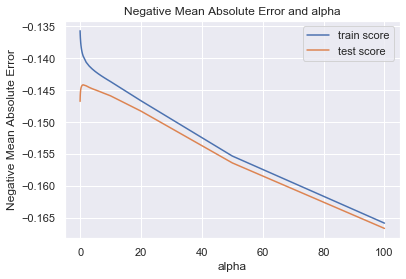

In [160]:
# plotting mean test and train scoes with alpha 
#ridge_res['param_alpha'] = ridge_res['param_alpha'].astype('int32')

# plotting
plt.plot(ridge_res['param_alpha'], ridge_res['mean_train_score'])
plt.plot(ridge_res['param_alpha'], ridge_res['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

#### 8.1.2 Observations
* The above curve does show a reduction in error, but it's not very obvious as to what value it is at
* So, we do 2 things to improve this scenario:
    1. Plot Negative Mean Absolute Error only till values of $\alpha$ = 10
    2. Create a Data Frame with values of alpha and mean_test_score and look for the minimum error (i.e., max negative value or min absolute value of mean_test_score) in the Data Frame

In [161]:
ridge_res = pd.DataFrame(ridge_cv.cv_results_)
ridge_res = ridge_res[ridge_res['param_alpha']<=20]

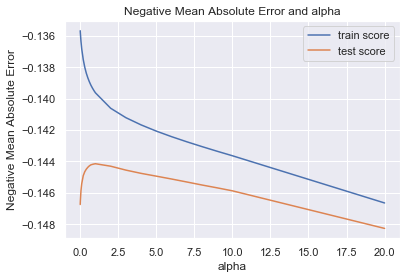

In [162]:
# plotting
plt.plot(ridge_res['param_alpha'], ridge_res['mean_train_score'])
plt.plot(ridge_res['param_alpha'], ridge_res['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [163]:
d = {'alpha': ridge_res['param_alpha'], 'mean_test_score': ridge_res['mean_test_score']}
resDf = pd.DataFrame(d)

resDf

,alpha,mean_test_score
0,0.0001,-0.146747
1,0.001,-0.146726
2,0.01,-0.146524
3,0.05,-0.145862
4,0.1,-0.145419
5,0.2,-0.144906
6,0.3,-0.144657
7,0.4,-0.144496
8,0.5,-0.144378
9,0.6,-0.144286


In [164]:
minid = abs(resDf['mean_test_score']).idxmin()
alpha = resDf.alpha[minid]
print(alpha)

1.0


#### 8.1.4 Observations, $\alpha$ value
* From the **Negative Mean Absolute Error** curve we can see that the min error is just below `-0.144`
* From the values of the Negative Mean Absolute Error shown in the above DF, we can see that the minimum error value is `-0.144150`
* This occurs at an $\alpha$ of 1
* We now run ridge regression with an alpha of 1

In [165]:
ridge = Ridge(alpha=alpha)

ridge.fit(X_train_rfe, y_train)
ridge.coef_

array([ 0.2413567 ,  0.17543812,  0.28266864, -0.17187884,  0.55079997,
        0.27745579,  0.364756  ,  0.21124303, -0.14949775,  0.29982313,
        0.20146055,  0.28571737,  0.46061945,  0.37065234,  0.16762809,
        0.35976173,  0.24578967,  0.46523078, -0.38440559, -0.19021517,
       -0.1769564 , -0.19397706,  0.22885387,  0.0729686 , -0.22792501])

* We see from the above, that there are 25 coefficients corresponding to all the 25 independent variables
* None of them has been reduced to 0, as is expected from Ridge Regression
* Below, we construct a dataframe of the variables and their coefficients, in order to map the coefficients to the corresponding independent variables

In [166]:
coefDfRidge = pd.DataFrame()
coefDfRidge['Variables'] = X_train_rfe.columns
coefDfRidge['Coefficients'] = ridge.coef_
coefDfRidge

,Variables,Coefficients
0,1stFlrSF,0.241357
1,2ndFlrSF,0.175438
2,CentralAirLvl,0.282669
3,MSSubClass_190,-0.171879
4,MSZoning_FV,0.550800
5,MSZoning_RH,0.277456
6,MSZoning_RL,0.364756
7,MSZoning_RM,0.211243
8,Neighborhood_MeadowV,-0.149498
9,Neighborhood_NridgHt,0.299823


#### 8.1.5 Observations (important variables)
From the above dataframe we see that the following variables are important in the positive sense (increase price):
1. `MS_ZoningFV` (Coef: `0.550800`) (house being in a Floating Village Residential area) increases its price quite significantly 
2. `RoofMatl_CompShg` (Coef: `0.460619`) and `RoofMatl_Metal` (Coef: `0.370652`) increase th house price drastically - implies that a lot of emphasis is given on the roof-material
3. `MSZoning_RL` (low-desity population, residential area) has good demand, implying people prefer peaceful areas (Coef: `0.364756`)
4. `CentralAirLvl` (Coef: `0.282669`) - Having a Centralized AC is important

The foll variables affect the house price negatively:
1. `Exterior1st_BrkComm` (Coef: `-0.384406`) - Common brick houses are not preferred
2. `BldgType_Duplex` (Coef: `-0.227925`) - Duplex houses reduce the sale price of houses - this is a bit counter-intuitive since 1stFlrSF has a high linear relationship with SalePrice. Possibly, people prefer separate 2-floor houses

In [167]:
y_train_pred = ridge.predict(X_train_rfe)
r2_train_ridge = sklearn.metrics.r2_score(y_train, y_train_pred)
print(r2_train_ridge)

0.769294276148756


In [168]:
col = X_test.columns[rfe.support_]
X_test_rfe = X_test[col]
y_test_pred = ridge.predict(X_test_rfe)
r2_test_ridge = sklearn.metrics.r2_score(y_test, y_test_pred)
print(r2_test_ridge)

0.6544167820613301


#### 8.1.6 Conclusion on Ridge Regression
- None of the varibales is reduced to 0
- The difference between the r2-score of Train and Test sets is lower than that for OLS
- This is due to regularization using ridge-regression

### 8.2 Lasso

* **Given the fact that the minimum error occured at an $\alpha$ value of 1, we try Lasso only till 1.0**
* Again, we consider 4-fold Cross-Validation

In [169]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

lasso = Lasso()

# cross validation
lasso_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_cv.fit(X_train_rfe, y_train) 

Fitting 4 folds for each of 14 candidates, totalling 56 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:    0.7s finished


GridSearchCV(cv=4, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

#### 8.2.1 Resuts of Lasso CV
- We now check the results of running Lasso Regression using the `cv_results_` parameter and creating a DF out of it
- We also plot the **Negative Mean Absolute Error**, against different values of $\alpha$ 
- The mean here implies taking the mean-error across all the Cross-Validation sets

In [170]:
lasso_res = pd.DataFrame(lasso_cv.cv_results_)
lasso_res = lasso_res[lasso_res['param_alpha']<=200]
lasso_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.012582,0.006813,0.003555,0.001211,0.0001,{'alpha': 0.0001},-0.149885,-0.147814,-0.144620,-0.141476,-0.145949,0.003192,2,-0.136233,-0.139758,-0.134689,-0.136055,-0.136683,0.001873
1,0.005211,0.000731,0.003419,0.000770,0.001,{'alpha': 0.001},-0.152785,-0.138228,-0.146768,-0.144701,-0.145621,0.005199,1,-0.139511,-0.146830,-0.141819,-0.143434,-0.142899,0.002664
2,0.005085,0.000496,0.002600,0.000078,0.01,{'alpha': 0.01},-0.168001,-0.150066,-0.170754,-0.168425,-0.164312,0.008291,3,-0.159604,-0.167533,-0.161717,-0.163808,-0.163166,0.002927
3,0.004917,0.000559,0.002911,0.000382,0.05,{'alpha': 0.05},-0.209923,-0.197864,-0.218651,-0.204788,-0.207806,0.007584,4,-0.202683,-0.213647,-0.204210,-0.209120,-0.207415,0.004313
4,0.004736,0.000510,0.003326,0.000751,0.1,{'alpha': 0.1},-0.238781,-0.232822,-0.245562,-0.232700,-0.237466,0.005281,5,-0.232561,-0.243959,-0.235054,-0.237554,-0.237282,0.004240


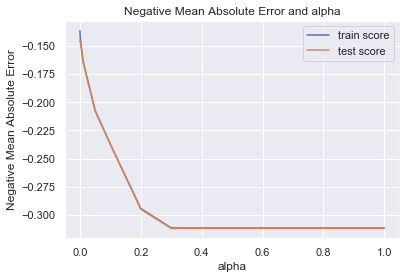

In [171]:
# plotting mean test and train scoes with alpha 

plt.plot(lasso_res['param_alpha'], lasso_res['mean_train_score'])
plt.plot(lasso_res['param_alpha'], lasso_res['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

#### 8.2.2 Observations
* There is absolutely no difference in the training and test curves, from the above plot
* The test curve absolutely follows the training curve
* In a way, this is a good thing, since this means we have got a very general model that fits equally well to training and test sets
* However, to find out the point of minimum error, let's plot only upto $\alpha$ of 0.1
* Let's also print a Data Frame of $\alpha$ values and min_test_score (Negative Mean Absolute Error)
* We'll then choose the value of $\alpha$ that corresponds to the min error and run that model on the test set

In [172]:
lasso_res = pd.DataFrame(lasso_cv.cv_results_)
lasso_res = lasso_res[lasso_res['param_alpha']<=0.1]

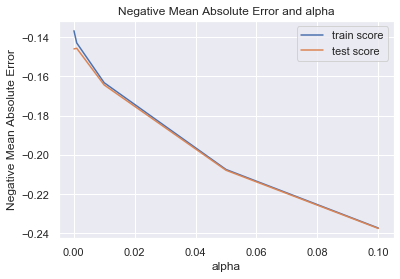

In [173]:
plt.plot(lasso_res['param_alpha'], lasso_res['mean_train_score'])
plt.plot(lasso_res['param_alpha'], lasso_res['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

* There seems to be a small blip that might signify reduction in error very near to 0
* We now plot only till alpha values of 0.04
* We also create a DF with error for values of $\alpha$ till 0.04 (actually 0.04 is not a considered value of $\alpha$ at all)

In [174]:
lasso_res = pd.DataFrame(lasso_cv.cv_results_)
lasso_res = lasso_res[lasso_res['param_alpha']<=0.04]

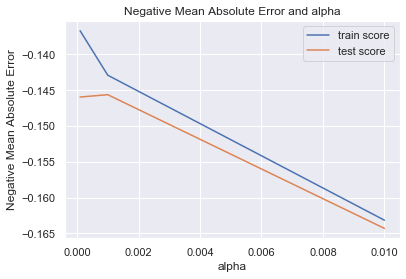

In [175]:
plt.plot(lasso_res['param_alpha'], lasso_res['mean_train_score'])
plt.plot(lasso_res['param_alpha'], lasso_res['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [176]:
d = {'alpha': lasso_res['param_alpha'], 'mean_test_score': lasso_res['mean_test_score']}
resDf = pd.DataFrame(d)

resDf

,alpha,mean_test_score
0,0.0001,-0.145949
1,0.001,-0.145621
2,0.01,-0.164312


In [177]:
minid = abs(resDf['mean_test_score']).idxmin()
alpha = resDf.alpha[minid]
print(f'alpha (min error) = {alpha}')

alpha (min error) = 0.001


#### 8.2.3 Observations and $\alpha$ value
* We can see from the plot that the min value of error occurs at an $\alpha$ value of around 0.001
* From the Data Frame, it's clear that it is indeed 0.001
* We now run Lasso Regression for 0.001

In [178]:
lasso = Lasso(alpha=alpha)      
lasso.fit(X_train_rfe, y_train) 
lasso.coef_

array([ 0.23921396,  0.17418445,  0.28719097, -0.05760592,  0.33527721,
        0.        ,  0.15866631, -0.        , -0.07701713,  0.29100603,
        0.09465929,  0.        ,  0.07979562,  0.        , -0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.23244228, -0.        , -0.2049533 ])

* From the above, we see that there are only 12 significant coefficients in the model
* The rest have been reduced to 0 through Lasso Regression
* Below, we create a DF to map coefficients to the independent variables

In [179]:
coefDfLasso = pd.DataFrame()
coefDfLasso['Variables'] = X_train_rfe.columns
coefDfLasso['Coefficients'] = lasso.coef_
coefDfLasso

,Variables,Coefficients
0,1stFlrSF,0.239214
1,2ndFlrSF,0.174184
2,CentralAirLvl,0.287191
3,MSSubClass_190,-0.057606
4,MSZoning_FV,0.335277
5,MSZoning_RH,0.000000
6,MSZoning_RL,0.158666
7,MSZoning_RM,-0.000000
8,Neighborhood_MeadowV,-0.077017
9,Neighborhood_NridgHt,0.291006


#### 8.2.4 Observations on coefficients
- Just like in Ridge Regression, `MSZoning_FV`, `Neighborhood_NridgHt`, `CentralAirLvl` and `Functional_Typ` are the significant variables with positive-effect, albeit with lower coefficient values
- Though all variables are not the same, quite a few of them match
- `BldgType_Duplex` is the only significant variable with negative-effect

In [180]:
y_train_pred = lasso.predict(X_train_rfe)
r2_train_lasso = sklearn.metrics.r2_score(y_train, y_train_pred)
print(r2_train_lasso)

0.7465942297685939


In [181]:
col = X_test.columns[rfe.support_]
X_test_rfe = X_test[col]
y_test_pred = lasso.predict(X_test_rfe)
r2_test = sklearn.metrics.r2_score(y_test, y_test_pred)
print(r2_test)

0.6708491726507487


#### 8.2.5 Conclusions on Lasso regression
- Again, the training r2-score is lower than that of OLS
- However, the difference between the training and test r2-scores are lesser than not only OLS, but also Ridge regression
- Further, as many as 13 coefficients have been made 0, but with very little impact on prediction, as indicated by the r2-score

## 9.0 Part II

#### Req 1

What is the optimal value of alpha for ridge and lasso regression? What will be the changes in the model if you choose double the value of alpha for both ridge and lasso? What will be the most important predictor variables after the change is implemented?


#### Ridge Regression

In [182]:
ridge = Ridge(alpha=2.0)

ridge.fit(X_train_rfe, y_train)
ridge.coef_

array([ 0.24009006,  0.17497014,  0.28454608, -0.12227001,  0.45796756,
        0.18405749,  0.27868806,  0.12372513, -0.14057008,  0.29700354,
        0.1835577 ,  0.18092419,  0.29345274,  0.19119396,  0.05433141,
        0.18105301,  0.10806145,  0.28403521, -0.2564662 , -0.12696634,
       -0.15187909, -0.12513339,  0.22787927,  0.02496748, -0.2225195 ])

In [183]:
coefDfRidge = pd.DataFrame()
coefDfRidge['Variables'] = X_train_rfe.columns
coefDfRidge['Coefficients'] = ridge.coef_
coefDfRidge

,Variables,Coefficients
0,1stFlrSF,0.240090
1,2ndFlrSF,0.174970
2,CentralAirLvl,0.284546
3,MSSubClass_190,-0.122270
4,MSZoning_FV,0.457968
5,MSZoning_RH,0.184057
6,MSZoning_RL,0.278688
7,MSZoning_RM,0.123725
8,Neighborhood_MeadowV,-0.140570
9,Neighborhood_NridgHt,0.297004


* We can see that the coefficient values have all changed

In [184]:
y_train_pred = ridge.predict(X_train_rfe)
r2_train_ridge = sklearn.metrics.r2_score(y_train, y_train_pred)
print(r2_train_ridge)

0.762199722152491


In [185]:
col = X_test.columns[rfe.support_]
X_test_rfe = X_test[col]
y_test_pred = ridge.predict(X_test_rfe)
r2_test_ridge = sklearn.metrics.r2_score(y_test, y_test_pred)
print(r2_test_ridge)

0.6630839090446172


* There's very little difference in the r2-score of the training set
* However, there is a 1% increase in the test-set r2-scrore

#### Lasso regression

In [186]:
lasso = Lasso(alpha=0.002)      
lasso.fit(X_train_rfe, y_train) 
lasso.coef_

array([ 0.23846732,  0.17291903,  0.28362916, -0.01614757,  0.30449139,
        0.        ,  0.14607558, -0.01042871, -0.        ,  0.27702667,
        0.        ,  0.        ,  0.01253378,  0.        , -0.        ,
       -0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.21786526, -0.        , -0.18105088])

* Not only have the coefficient values changed, the number of coefficients is now 11, instead of 12

In [187]:
coefDfLasso1 = pd.DataFrame()
coefDfLasso1['Variables'] = X_train_rfe.columns
coefDfLasso1['Coefficients'] = lasso.coef_
coefDfLasso1

,Variables,Coefficients
0,1stFlrSF,0.238467
1,2ndFlrSF,0.172919
2,CentralAirLvl,0.283629
3,MSSubClass_190,-0.016148
4,MSZoning_FV,0.304491
5,MSZoning_RH,0.000000
6,MSZoning_RL,0.146076
7,MSZoning_RM,-0.010429
8,Neighborhood_MeadowV,-0.000000
9,Neighborhood_NridgHt,0.277027


In [188]:
y_train_pred = lasso.predict(X_train_rfe)
r2_train_lasso = sklearn.metrics.r2_score(y_train, y_train_pred)
print(r2_train_lasso)

0.7398871815760386


In [189]:
col = X_test.columns[rfe.support_]
X_test_rfe = X_test[col]
y_test_pred = lasso.predict(X_test_rfe)
r2_test = sklearn.metrics.r2_score(y_test, y_test_pred)
print(r2_test)

0.6724712516562261


* The training-set r2-score has reduced, somewhat, due to alpha being higher
* However, the test-set r2-score has increased, but marginally

#### Req 2

In order to find the 5 most important predictor variables for Lasso, we sort the DF, **coefDfLasso** on the coefficient values and pick the ones with highest values, while not forgetting to pick the ones with lowest values as well

In [190]:
coefDfLasso.sort_values(by = 'Coefficients', ascending = False, inplace = True)
coefDfLasso

,Variables,Coefficients
4,MSZoning_FV,0.335277
9,Neighborhood_NridgHt,0.291006
2,CentralAirLvl,0.287191
0,1stFlrSF,0.239214
22,Functional_Typ,0.232442
1,2ndFlrSF,0.174184
6,MSZoning_RL,0.158666
10,Neighborhood_Veenker,0.094659
12,RoofMatl_CompShg,0.079796
7,MSZoning_RM,-0.000000
